In [31]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats

np.random.seed(27);
torch.manual_seed(27);

In [32]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
DEVICE = 'cuda'
NDIM = 10

## Torus model

In [4]:
def model(v):
    x = v + np.random.randn(len(v))*0.01
    return dict(x=x)

In [5]:
np.random.seed(0)
v0 = np.random.rand(NDIM)
obs0 = model(v0)
obs0, v0

({'x': array([0.55025394, 0.7297321 , 0.61037375, 0.54609993, 0.42809343,
         0.64923086, 0.452528  , 0.88972142, 0.96679344, 0.37490056])},
 array([0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ,
        0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152]))

In [6]:
prior = swyft.Prior.from_uv(lambda u: u, NDIM)

In [7]:
simulator = swyft.Simulator(model, sim_shapes = dict(x=(NDIM,)))
store = swyft.MemoryStore(NDIM, simulator = simulator)

DEBUG:root:Creating new empty MemoryStore.
DEBUG:root:  params = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9']
INFO:root:Creating new store.
DEBUG:root:  sim_shapes = {'x': (10,)}


In [8]:
partitions = list(range(NDIM))
micro = swyft.Microscope(partitions, prior, obs0, store = store, device = DEVICE)

In [12]:
micro.focus(max_rounds=5)

In [13]:
post = swyft.Posteriors.from_Microscope(micro)
#post.infer([(0, 1), (0, 2), (1, 2)], device = DEVICE)

In [106]:
samples = micro.posteriors[1].sample(100000, obs0)

In [107]:
entropy = [v['entropy'] for v in swyft.utils.sample_diagnostics(samples).values()]
entropy

[-3.1874627071695314,
 -3.1445337051931004,
 -3.2197370282809725,
 -3.20434606531558,
 -3.2454636414686537,
 -3.232805927093649,
 -3.271800779366108,
 -3.191161830171316,
 -3.3271178312288323,
 -3.2370134553787033]

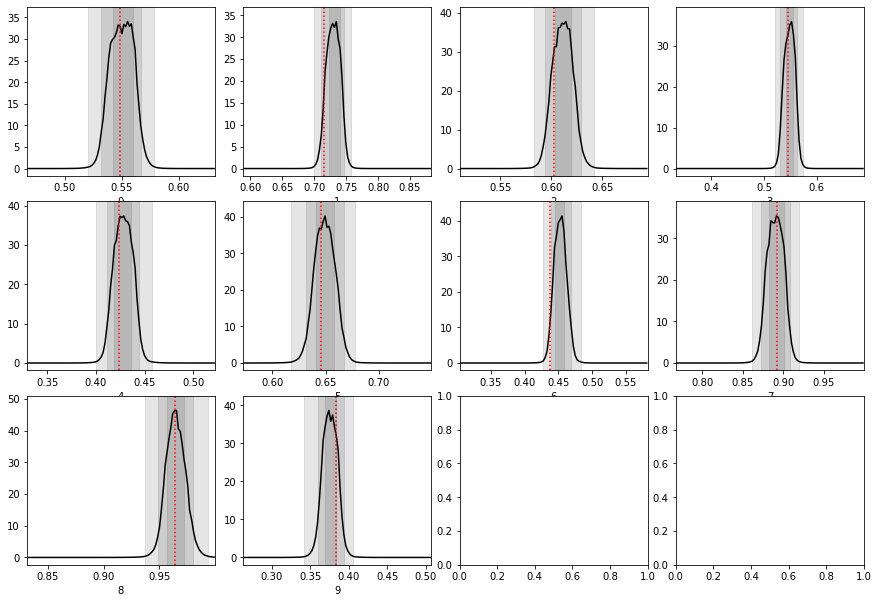

In [108]:
swyft.plot1d(samples, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ncol = 4, truth = v0)

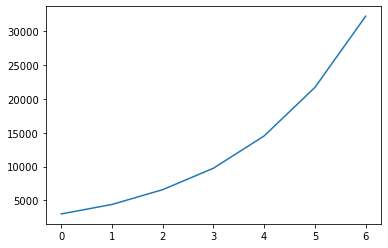

In [109]:
N_hist = [len(d) for d in micro.datasets][:-1]
plt.plot(N_hist)

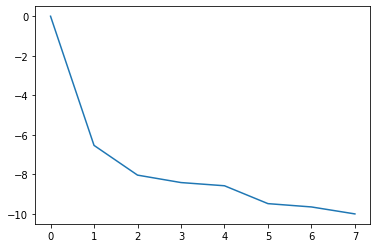

In [110]:
plt.plot(np.log10(micro.volumes))

In [94]:
samples_list = [post.sample(100000, obs0) for post in micro.posteriors]

In [95]:
diags_list = [swyft.sample_diagnostics(samples) for samples in samples_list]

(-4.186231652783418, -2.1862316527834182)

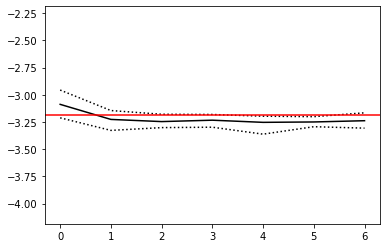

In [101]:
gentropy_list = np.array([[x['entropy'] for x in diag.values()] for diag in diags_list])
plt.plot(entropy_list.min(axis=1), 'k:')
plt.plot(entropy_list.max(axis=1), 'k:')
plt.plot(entropy_list.mean(axis=1), 'k')
entropy_true = stats.norm.entropy(0., 0.01)
plt.axhline(entropy_true, color='r')
plt.ylim([entropy_true-1, entropy_true + 1])

In [57]:
Ninit = 10000

In [22]:
micro2 = swyft.Microscope(partitions, prior, obs0, store = store, device = DEVICE, Ninit = Ninit, train_args = dict(nworkers = 4))
micro2.focus(max_rounds=1)

INFO:root:Starting round 1
DEBUG:root:Step 0: Initializing dataset for round 1
DEBUG:root:  dataset size N = 99924
INFO:root:  adding 97214 new samples to simulator store.
DEBUG:root:Step 1: Perform simulations for round 1
DEBUG:root:Step 1: Perform simulations for round 1
DEBUG:root:Step 2: Training for round 1
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([10])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 4
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience

In [23]:
post2 = swyft.Posteriors.from_Microscope(micro2)
samples2 = post2.sample(1000000, obs0)

In [34]:
entropy2 = [v['entropy'] for v in swyft.utils.sample_diagnostics(samples2).values()]
entropy2

[nan, nan, -3.221549009215169, nan, nan, nan, nan, nan, nan, nan]

(0.33, 0.42)

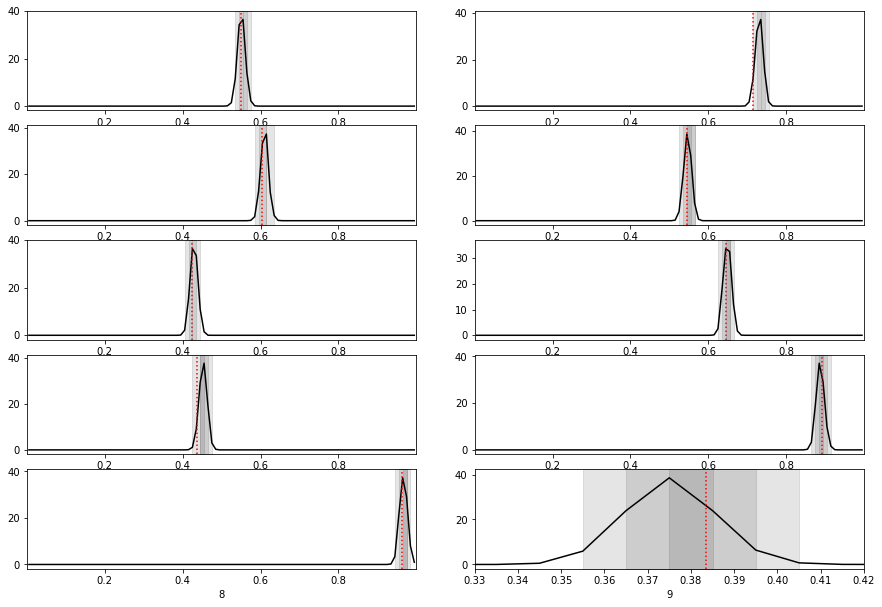

In [37]:
swyft.plot1d(samples2, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ncol = 2, truth = v0)
plt.xlim([0.33, 0.42])

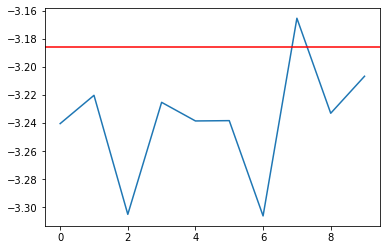

In [33]:
plt.plot(entropy)
plt.plot(entropy2)
entropy_true = stats.norm.entropy(0., 0.01)
plt.axhline(entropy_true, color='r')